In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/digipodium/Datasets/main/regression/house_pricing.csv")
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.nunique()

In [ ]:
sns.boxplot(data=df, x='City', y='Price')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.boxplot(data=df, x='Type', y='Price')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.boxplot(data=df, x='Beds', y='Price')
plt.show()

In [ ]:
sns.boxplot(data=df, x='Baths', y='Price')
plt.show()

In [ ]:
sns.regplot(data=df, x='SquareFeet', y='Price')

# pipeline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
text_cols = ['Type']
num_cols = ['SquareFeet', 'Beds', 'Baths']

X = df[text_cols + num_cols]
y = df['Price']

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
    test_size=0.2, 
    random_state=0)
cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, text_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reg', DecisionTreeRegressor())
])
# max_depth
scores = []
for i in range(2, 20):
    model.named_steps['reg'].set_params(max_depth=i)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    scores.append(r2_score(ytest, ypred))
plt.plot(range(2, 20), scores, marker='x', color='red', markeredgecolor='black')
plt.vlines(x=4, ymin=min(scores), ymax=max(scores), color='blue', linestyle='--',
        alpha=0.5)
plt.title('max_depth vs r2_score')
plt.xlabel('max_depth')
plt.ylabel('r2_score')
plt.xticks(range(2, 20))
plt.show()

In [ ]:
ypred = model.predict(Xtest)
print('R2:', r2_score(ytest, ypred))
print('MAE:', mean_absolute_error(ytest, ypred))
print('MSE:', mean_squared_error(ytest, ypred))

# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
    test_size=0.2, 
    random_state=0)
cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, text_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reg', DecisionTreeRegressor())
])
param_grid = {
    'reg__criterion': ['sqaured_error', 'friedman_mse', 'absolute_error'],
    'reg__max_depth': range(2, 20),
    'reg__ccp_alpha': np.linspace(0.0, 0.1, 10)
}
# neg_mean_squared_error because scoring is opposite of loss
grid = GridSearchCV(model, param_grid, 
                    scoring='r2',
                    cv=4, 
                    verbose=1, 
                    n_jobs=-1)
grid

In [ ]:
grid.fit(X, y)

In [ ]:
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

In [ ]:
grid.best_params_

In [ ]:
final_model = grid.best_estimator_

In [ ]:
# ypred = final_model.predict(Xtest)
# print('R2:', r2_score(ytest, ypred))
# print('MAE:', mean_absolute_error(ytest, ypred))
# print('MSE:', mean_squared_error(ytest, ypred))

In [ ]:
sns.lineplot(data=results.head(50), x='rank_test_score', y='mean_test_score', marker='o')

In [ ]:
sns.histplot(data=results, x='mean_test_score', bins=20, kde=True)

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(final_model.named_steps['reg'], 
        feature_names=X.columns, 
        filled=True, 
        fontsize=10)
plt.show()

validation_curve and learning curve

In [ ]:
df = pd.read_csv('../datasets/housing.csv')
df.columns

In [ ]:
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value')

In [ ]:
X = df.drop(columns=['median_house_value','ocean_proximity'])
y = df['median_house_value']

In [ ]:
from sklearn.model_selection import ValidationCurveDisplay
max_depths = list(range(2, 25))
disp = ValidationCurveDisplay.from_estimator(
    DecisionTreeRegressor(),
    X,y,
    param_name='max_depth',
    param_range=max_depths,
    scoring='r2',
    n_jobs=-1,
    std_display_style='errorbar'
)

In [ ]:
from sklearn.model_selection import ValidationCurveDisplay
max_depths = list(range(2, 25))
disp = ValidationCurveDisplay.from_estimator(
    DecisionTreeRegressor(),
    X,y,
    param_name='max_depth',
    param_range=max_depths,
    scoring='neg_mean_squared_error',
    negate_score=True,
    n_jobs=-1,
    std_display_style='errorbar'
)

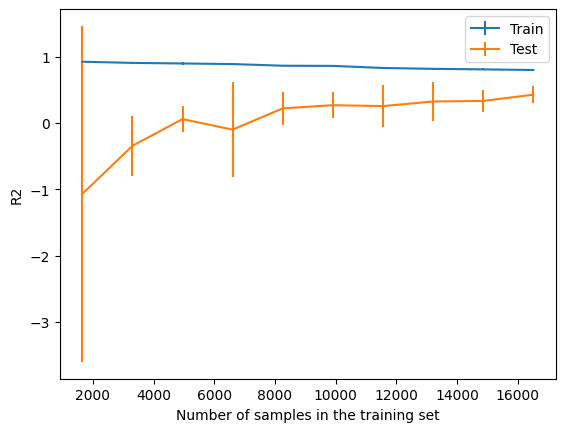

In [104]:
from sklearn.model_selection import LearningCurveDisplay

disp = LearningCurveDisplay.from_estimator(
    DecisionTreeRegressor(max_depth=9),
    X,y,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    std_display_style='errorbar'
)

In [105]:
from sklearn.model_selection import learning_curve

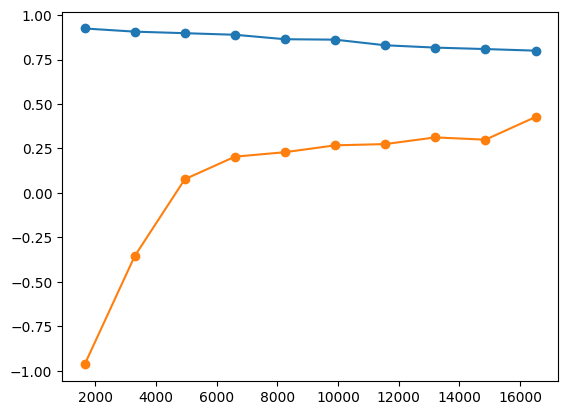

In [112]:
results = learning_curve(
    DecisionTreeRegressor(max_depth=9),
    X,y,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_sizes, train_scores, test_scores = results
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), marker='o', label='test')